# T/S Diagram from SOSE

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

In [15]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-sose'), consolidated=True)

In [17]:
coords = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)

In [18]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [19]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [21]:
salt = dsr.SALT.isel(**lat_range, **lon_range).mean(dim='time')
temp = dsr.THETA.isel(**lat_range, **lon_range).mean(dim='time')

In [24]:
from dask.distributed import Client

client = Client("tcp://10.32.0.41:40233")
client

Client Scheduler: tcp://10.32.0.41:40233 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 19 Cores: 38 Memory: 218.50 GB


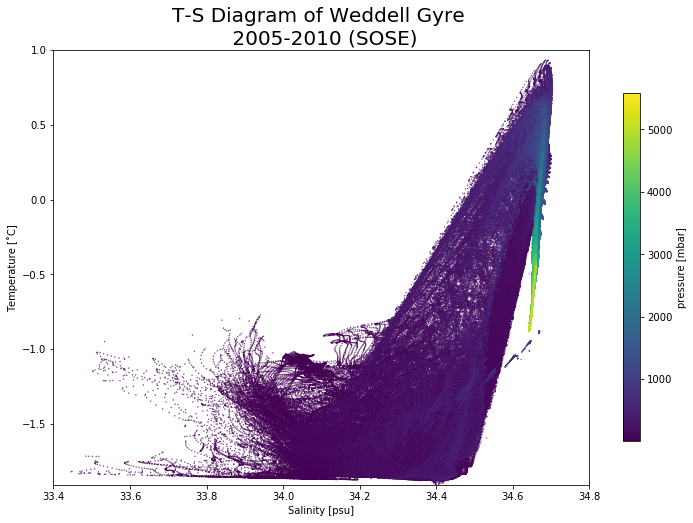

In [46]:
_, _, lev_broadcasted = xr.broadcast(salt, temp, dsr.Z)

plt.figure(figsize=(12,8))
scat = plt.scatter(salt, temp, c=abs(lev_broadcasted), marker='.', s=0.5)
plt.colorbar(scat, label='pressure [mbar]', shrink=0.8)

plt.xlim(33.4, 34.8)
plt.ylim(-1.906954288482666, 1)

plt.xlabel('Salinity [psu]')
plt.ylabel('Temperature [˚C]')
plt.title('T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20);

# xhistogram T/S Diagram from SOSE